*TP 2 filtrage-Restauration*

In [1]:
#%% SECTION 1 inclusion de packages externes 


import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

# POUR LA MORPHO
#from skimage.morphology import watershed 
from skimage.feature import peak_local_max
from skimage.segmentation import watershed


In [2]:
#%% SECTION 2 fonctions utiles pour le TP

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "C:/Users/akilh/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/GIMP 2.10.34.lnk" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def quantize(im,n=2):
    """
    Renvoie une version quantifiee de l'image sur n (=2 par defaut) niveaux  
    """
    imt=np.float32(im.copy())
    if np.floor(n)!= n or n<2:
        raise Exception("La valeur de n n'est pas bonne dans quantize")
    else:
        m=imt.min()
        M=imt.max()
        imt=np.floor(n*((imt-m)/(M-m)))*(M-m)/n+m
        imt[imt==M]=M-(M-m)/n #cas des valeurs maximales
        return imt
    

def seuil(im,s):
    """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    """
    imt=np.float32(im.copy())
    mask=imt<s
    imt[mask]=0
    imt[~mask]=255
    return imt

def gradx(im):
    "renvoie le gradient dans la direction x"
    imt=np.float32(im)
    gx=0*imt
    gx[:,:-1]=imt[:,1:]-imt[:,:-1]
    return gx

def grady(im):
    "renvoie le gradient dans la direction y"
    imt=np.float32(im)
    gy=0*imt
    gy[:-1,:]=imt[1:,:]-imt[:-1,:]
    return gy

def view_spectre(im,option=1,hamming=False):
    """ affiche le spectre d'une image
     si option =1 on affiche l'intensite de maniere lineaire
     si option =2 on affiche le log
     si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
     """
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    if hamming:
        XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
        YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
        imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    aft=np.fft.fftshift(abs(np.fft.fft2(imt)))
    
    if option==1:
        viewimage(aft)
    else:
        viewimage(np.log(0.1+aft))


def filterlow(im): 
    """applique un filtre passe-bas parfait a une image (taille paire)"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    mask=(abs(XX)<tx/4) & (abs(YY)<ty/4)
    imtf=np.fft.fft2(imt)
    imtf[~mask]=0
    return np.real(np.fft.ifft2(imtf))

def filtergauss(im):
    """applique un filtre passe-bas gaussien. coupe approximativement a f0/4"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    # C'est une gaussienne, dont la moyenne est choisie de sorte que
    # l'integrale soit la meme que celle du filtre passe bas
    # (2*pi*sig^2=1/4*x*y (on a suppose que tx=ty))
    sig=(tx*ty)**0.5/2/(pi**0.5)
    mask=np.exp(-(XX**2+YY**2)/2/sig**2)
    imtf=np.fft.fft2(imt)*mask
    return np.real(np.fft.ifft2(imtf))

def Get_values_without_error(im,XX,YY):
    """ retouren une image de la taille de XX et YY 
     qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
     pas """
    sh=XX.shape
    defaultval=0;
    if len(im.shape)>2: #color image !
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp
    
    return imout        

def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
    """
   %
%Effectue la transformation geometrique d'une image par
%une rotation + homothetie 
%
% x' = alpha*cos(theta)*(x-x0) - alpha*sin(theta)*(y-y0) + x0
% y' = alpha*sin(theta)*(x-x0) + alpha*cos(theta)*(y-y0) + y0 
%
% theta : angle de rotation en degres
% alpha : facteur d'homothetie (defaut=1)
% x0, y0 : centre de la rotation (defaut=centre de l'image)
% ech : plus proche voisin (defaut=0) ou bilineaire (1)
% clip : format de l'image originale (defaut=True), image complete (False)
% 

    """ 
    dy=im.shape[0]
    dx=im.shape[1]
    
    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        #ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())
        
    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1)) 
    
    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))
    
    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # plus proche voisin
        out=Get_values_without_error(im,Xout,Yout)
    else:  #bilineaire 
        assert ech == 1 , "Vous avez choisi un echantillonnage inconnu"
        Y0=np.floor(Yout-0.5)+0.5 # on va au entier+0.5 inferieur
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1 #points entiers
        PoidsY[Y0==Y1]=1 #points entiers
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out

def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,mask):
    """ renvoie la convolution de l'image avec le mask. Le calcul se fait en 
utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
les images en niveau de gris.
"""
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def filtre_inverse(im,mask):
    """ renvoie l'inverse de mask applique a im.
    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)/fft2(mm))
    
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out


def median_filter(im,typ=1,r=1,xy=None):
    """ renvoie le median de l'image im.
    si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    si typ==2 : disque de rayon r
    si typ==3 alors xy est un couple de liste de x et liste de y
         ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois. 
         """
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negatif
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positif
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    #print (lx,ly)
    #print(ttx,tty)
    #print(im[deby+ly[k]:tty+ly[k]+deby,debx+lx[k]:debx+ttx+lx[k]].reshape(-1).shape)
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

def wiener(im,K,lamb=0):
    """effectue un filtrage de wiener de l'image im par le filtre K.
       lamb=0 donne le filtre inverse
       on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
       avec une regularisation qui permet de ne pas trop augmenter le bruit.
       """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+lamb*w2)
    #filtrage de wiener
    fout=g*mul
    
    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

def var_image(im,x0,y0,x1,y1):
    patch=im[y0:y1+1,x0:x1+1]
    return patch.var()

**1-Transformation geometrique**


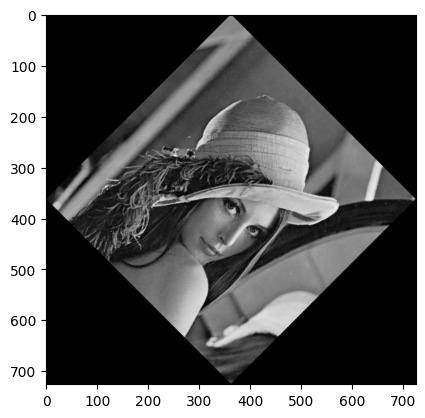

In [3]:
im=skio.imread('images/lena.tif')

flipped= rotation(im, 45, clip=False)
plt.imshow(flipped, cmap="gray")

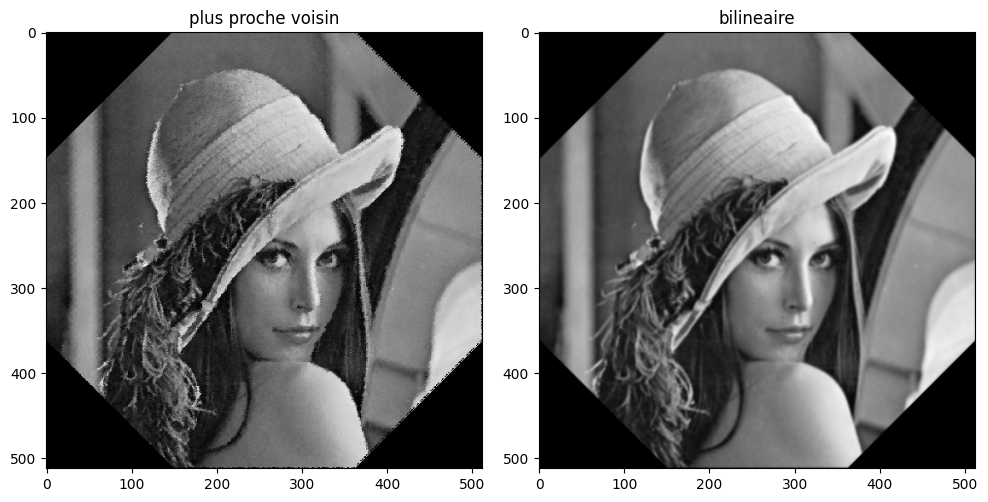

In [4]:
flipped_ppv=im
flipped_bil=im
for i in range(8):
    flipped_bil= rotation(flipped_bil, 45,ech=1, clip=True)
    flipped_ppv= rotation(flipped_ppv, 45, clip=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(flipped_ppv, cmap='gray')
axes[0].set_title('plus proche voisin')

axes[1].imshow(flipped_bil, cmap='gray')
axes[1].set_title('bilineaire')

plt.tight_layout()
plt.show()

remarquons que la methode bilineare garde une images claire meme apres 8 rotation, alors que la methode ppv rend une image bruité (mauvaise qualité). Cette difference ne se voit pas apres une seule rotation  c'est normal, mais apres bcp d operations sur l image.


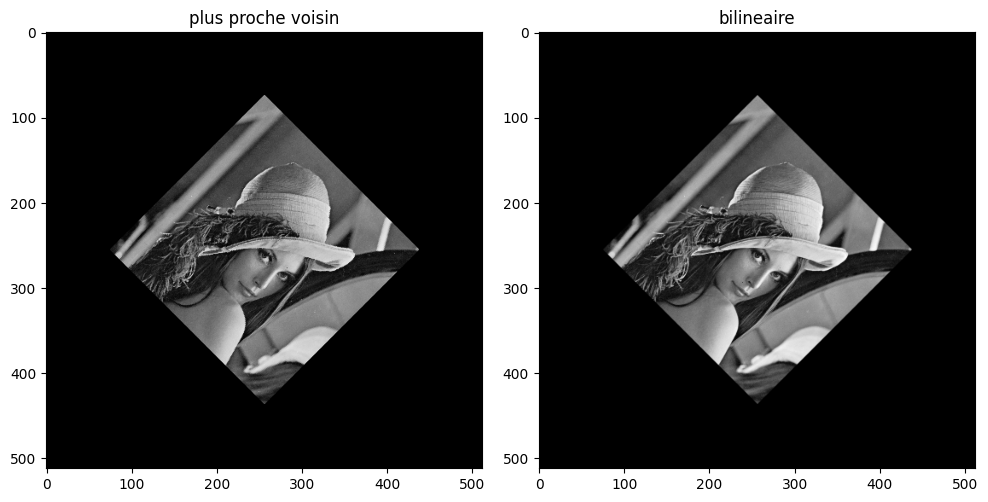

In [5]:
flipped_bil= rotation(im, alpha=1/2, theta= 45,ech=1, clip=True)
flipped_ppv= rotation(im, alpha=1/2, theta=45, clip=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(flipped_ppv, cmap='gray')
axes[0].set_title('plus proche voisin')

axes[1].imshow(flipped_bil, cmap='gray')
axes[1].set_title('bilineaire')

plt.tight_layout()
plt.show()

**3-Filtrage lineare et median**

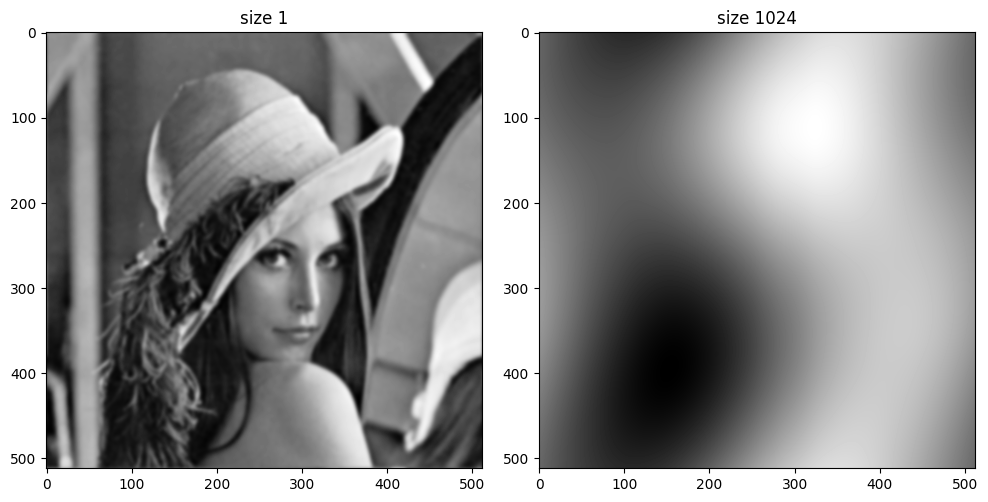

In [6]:

noyau_cte=get_cst_ker(2)

gfiltred1=filtre_lineaire(im, get_gau_ker(2))
gfiltred2=filtre_lineaire(im, get_gau_ker(100))
plt.imshow

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(gfiltred1, cmap='gray')
axes[0].set_title('size 1')

axes[1].imshow(gfiltred2, cmap='gray')
axes[1].set_title('size 1024')

plt.tight_layout()
plt.show()

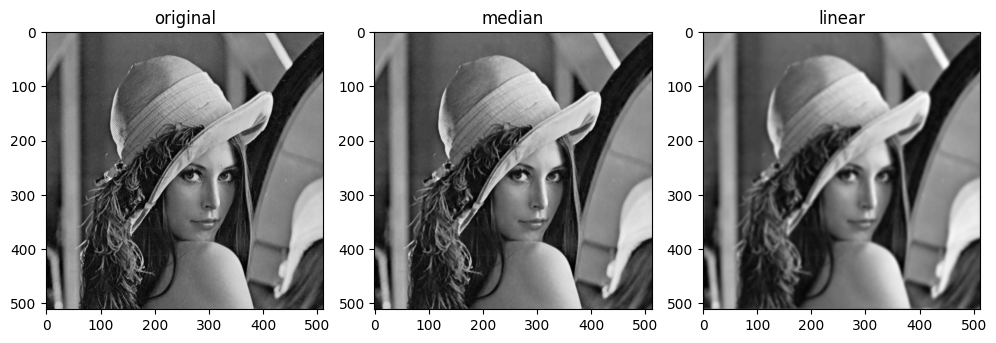

In [7]:
noyau_cte=get_cst_ker(2)

gfiltred1=filtre_lineaire(im, get_gau_ker(2))
gfiltred2=median_filter(im)
plt.imshow

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  
axes[0].imshow(im, cmap='gray')
axes[0].set_title('original')
axes[2].imshow(gfiltred1, cmap='gray')
axes[2].set_title('linear')

axes[1].imshow(gfiltred2, cmap='gray')
axes[1].set_title('median')

plt.tight_layout()
plt.show()

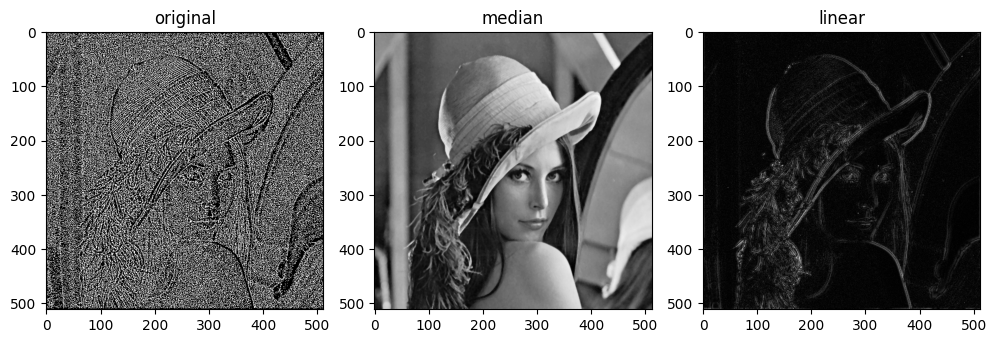

In [8]:
noyau_cte=get_cst_ker(2)

gfiltred1=filtre_lineaire(im, get_gau_ker(2))
gfiltred2=median_filter(im)
plt.imshow

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  
axes[0].imshow(abs(im-gfiltred2), cmap='gray')
axes[0].set_title('original')
axes[2].imshow(abs(im-gfiltred1), cmap='gray')
axes[2].set_title('linear')

axes[1].imshow(gfiltred2, cmap='gray')
axes[1].set_title('median')

plt.tight_layout()
plt.show()

Le filtre médian permet d'éliminer les valeurs aberrantes sans se limiter à faire un calcul de moyenne qui aura tendance à contaminer les valeurs voisines avec cette valeur aberrante et flouter l'image.

Le filtre médian respecte le contraste de l'image (si on multiplie toutes les valeurs par une constante positive, l'ordonnancement des valeurs est inchangé) et la luminosité de l'image (ajouter une constante ne modifie pas l'ordonnancement non plus).

Dans les zones où l'intensité est monotone (uniquement croissante ou uniquement décroissante) le filtre laisse l'image inchangée. Il respecte les contours, et élimine les valeurs extrêmes.

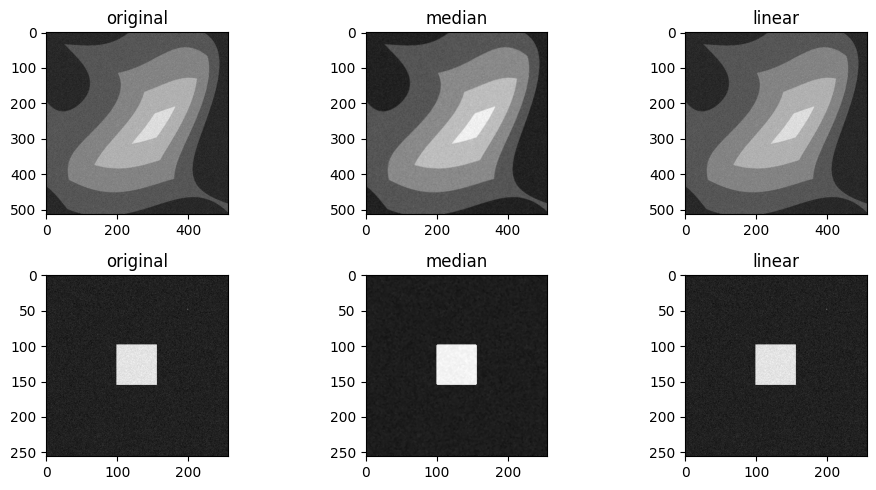

In [9]:
im=skio.imread('images/pyramide.tif')
im=noise(im, 10)
noyau_cte=get_cst_ker(2)

gfiltred1=filtre_lineaire(im, get_gau_ker(2))
gfiltred2=median_filter(im)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))  
axes[0][0].imshow(im, cmap='gray')
axes[0][0].set_title('original')
axes[0][2].imshow(im, cmap='gray')
axes[0][2].set_title('linear')

axes[0][1].imshow(gfiltred2, cmap='gray')
axes[0][1].set_title('median')

im=skio.imread('images/carre_orig.tif')
im=noise(im, 10)
noyau_cte=get_cst_ker(2)

gfiltred1=filtre_lineaire(im, get_gau_ker(2))
gfiltred2=median_filter(im)

axes[1][0].imshow(im, cmap='gray')
axes[1][0].set_title('original')
axes[1][2].imshow(im, cmap='gray')
axes[1][2].set_title('linear')

axes[1][1].imshow(gfiltred2, cmap='gray')
axes[1][1].set_title('median')
plt.tight_layout()
plt.show()

Remarquons que les images filtrés avec le filtre median sont plus lunineux. 


On peut evaluer la quantité du bruit residuel en prenant une partie de l image et apres multiplier par taille totale/taille. La quantité de bruit dqns cette pqrtie c est la variance de toute l image si on prend une partie ou limage originale etait de valeur constante(variance nulle avant).

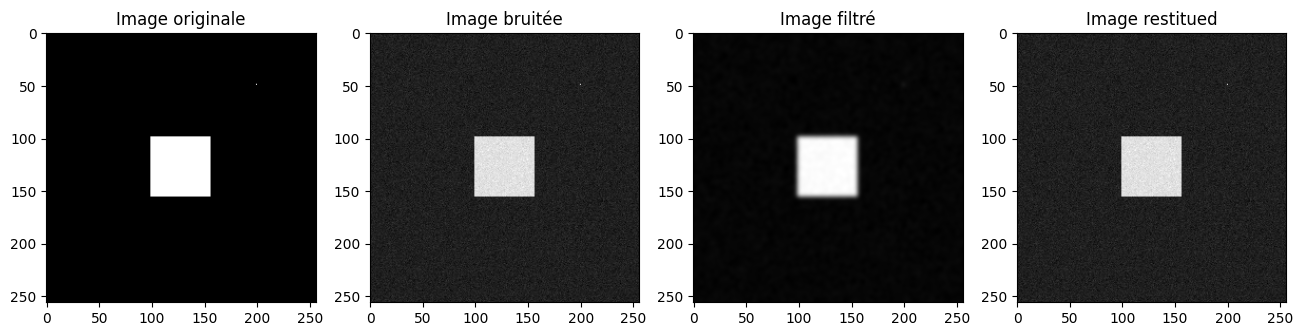

In [23]:
imo=skio.imread('images/carre_orig.tif')
im=noise(imo, 10)
filtred=filtre_lineaire(im, get_gau_ker(2))
restitued=wiener(filtred, get_gau_ker(2))
fig, ax = plt.subplots(1, 4, figsize=(16, 16))
ax[0].imshow(imo, cmap="gray")
ax[0].set_title("Image originale")
ax[2].imshow(filtred, cmap="gray")
ax[2].set_title("Image filtré")
ax[1].imshow(im, cmap="gray")
ax[1].set_title("Image bruitée")
ax[3].imshow(restitued, cmap="gray")
ax[3].set_title("Image restitued")
plt.show()

Lambda=1e-10
Lambda=0.0001
Lambda=0.001
Lambda=0.1


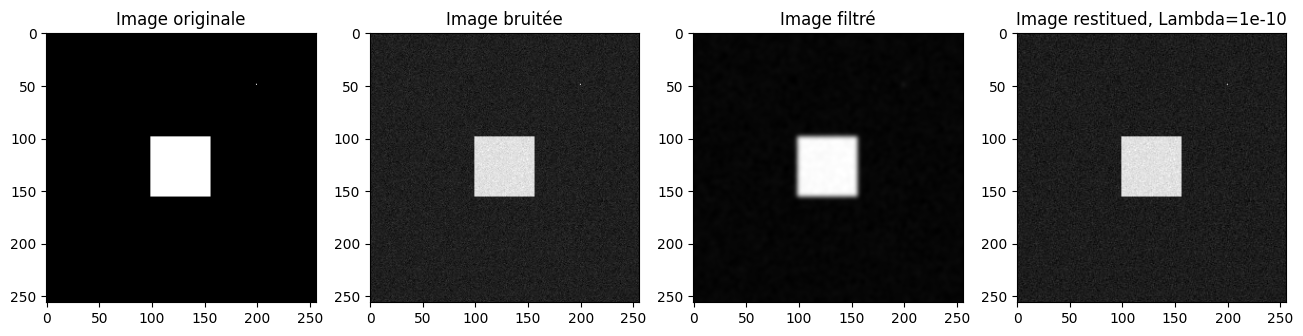

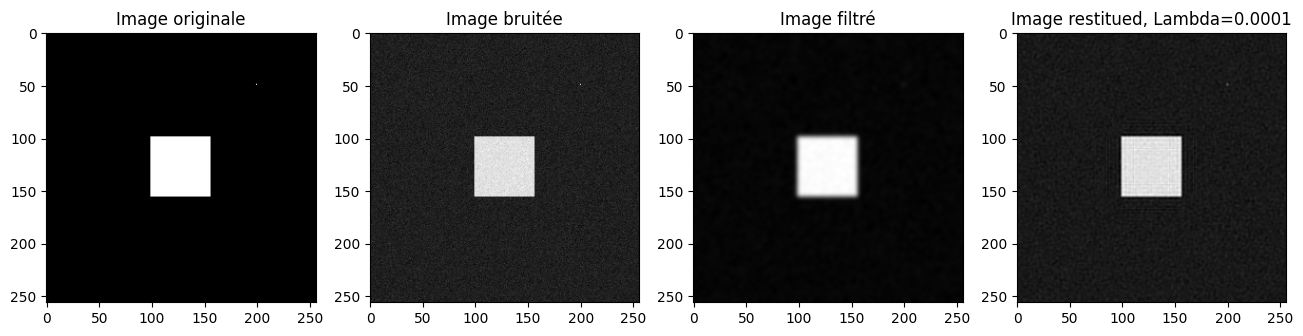

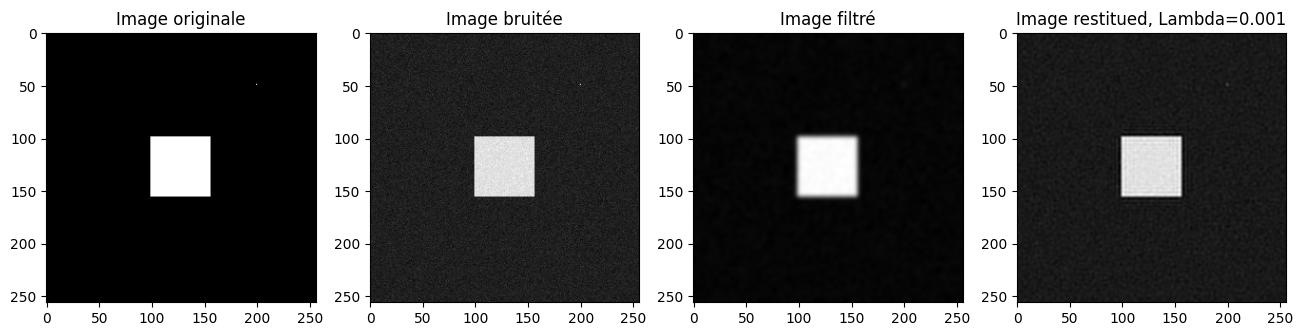

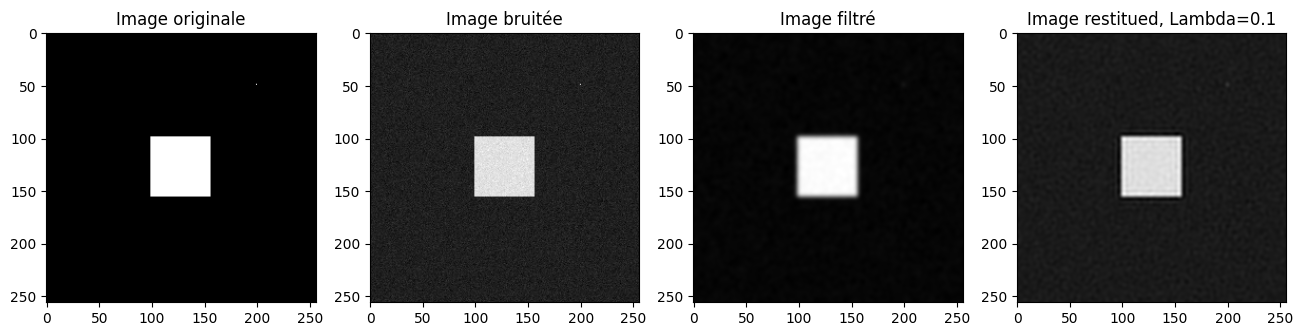

In [39]:
for lambda0 in [1e-10, 1e-4, 1e-3, 1e-1]: 
    print("Lambda=" + str(lambda0))
    restitued=wiener(filtred, get_gau_ker(2), lamb=lambda0)
    fig, ax = plt.subplots(1, 4, figsize=(16, 16))
    ax[0].imshow(imo, cmap="gray")
    ax[0].set_title("Image originale")
    ax[2].imshow(filtred, cmap="gray")
    ax[2].set_title("Image filtré")
    ax[1].imshow(im, cmap="gray")
    ax[1].set_title("Image bruitée")
    ax[3].imshow(restitued, cmap="gray")
    ax[3].set_title("Image restitued, Lambda=" + str(lambda0))

plt.show()